## Setup

Curried again from the work we did in the previous notebooks.

In [1]:
%%time

import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

frontages = gpd.read_file('../../data/processed/frontages.json').set_index('frontage_id')
blocks = gpd.read_file('../../data/processed/blocks.json').set_index('block_id')
buildings = gpd.read_file('../../data/processed/buildings.json').set_index('building_id')
blockfaces = gpd.read_file('../../data/processed/blockfaces.json').set_index('blockface_id')
sf = gpd.read_file('https://raw.githubusercontent.com/ResidentMario/geoplot-data/master/san-francisco.geojson')

trash = gpd.read_file('../../data/processed/trash.json').set_index('id')
trash = trash.assign(
    time=pd.to_datetime(trash.time)
)
filter_dates = (trash
 .assign(n=0)
 .set_index('time')
 .resample('D')
 .n.count()
 .where(lambda v: v < 100)
 .dropna()
 .index
)
trash = trash[~trash.time.map(lambda v: v.replace(hour=0, minute=0, second=0)).isin(filter_dates)]
trash = trash.drop(columns=['isSponsored', 'isValidated', 'likes'])
trash = trash[trash['time'] >= pd.to_datetime('October 1 2018')]

CPU times: user 20.7 s, sys: 824 ms, total: 21.5 s
Wall time: 21.5 s


In [2]:
%%time

trash = (
    gpd.sjoin(
        trash, gpd.GeoDataFrame([], geometry=[frontages.unary_union.buffer(0.0005)]),
        how="inner", op='intersects'
    )
)

/Users/alex/miniconda3/envs/trash-talk-dev/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  '(%s != %s)' % (left_df.crs, right_df.crs))


CPU times: user 5.8 s, sys: 104 ms, total: 5.91 s
Wall time: 5.93 s


In [3]:
%%time

import spaghetti as spgh
net = spgh.Network(in_data=frontages)
net.snapobservations(trash, 'trash')
updated_trash_points = spgh.element_as_gdf(net, pp_name='trash', snapped=True)

CPU times: user 46.6 s, sys: 254 ms, total: 46.9 s
Wall time: 47.2 s


In [4]:
%%time

from shapely.geometry import Point

trash_point_distances = (
    updated_trash_points.geometry.distance(Point(*frontages.total_bounds[[0, 3]])) * (360 / 0.001)
)

A = Point(frontages.total_bounds[[0, 3]])
B = Point(frontages.total_bounds[[2, 1]])

def lr(p):
    return 'right' if (B.x - A.x) * (p.y - A.y) - (B.y - A.y) * (p.x - A.x) > 0 else 'left'

trash = trash.assign(
    side=trash.geometry.map(lr),
    snap_distance=trash_point_distances.values,
    snap_geometry=updated_trash_points.geometry.values
)

CPU times: user 7.57 s, sys: 21.3 ms, total: 7.59 s
Wall time: 7.6 s


In [5]:
trash = trash.assign(type=trash['type'].map(lambda v: v if v != 'bottlesCans' else 'plastic'))

## Visual idea one: trash by Yelp data

In `02 Preliminary Exploration` we looked at several attributes of the buildings included in this dataset. In discussion with the team we hypothesized that Yelp ratings (both dollars and stars) are likely correlated with how much trash ends up in front of a business. Let's now put that to the test.

In [6]:
(trash
 .set_index('building_id')
 .join(buildings, how='left', lsuffix='_trash', rsuffix='_building')
 .groupby('avg_yelp_stars')
 .apply(lambda df: len(df) / len(df.index.unique()))
)

avg_yelp_stars
2.500000     2802.500000
3.000000     1523.333333
3.250000     1664.000000
3.500000     3727.500000
3.625000    15091.000000
3.750000     1501.666667
3.833333     3239.000000
4.000000     2106.000000
4.166667      242.000000
4.500000      894.100000
5.000000     3537.500000
dtype: float64

This doesn't show up in a naive rollup like this. Probably because different buildings are different sizes, so to get an accurate picture we have to account for the amount of sidewalk space the building occupies.

In [7]:
bldg_frontage_lengths = (
    frontages.groupby('building_id').geometry.apply(lambda srs: srs.length.sum()) * (360 / 0.001)
)

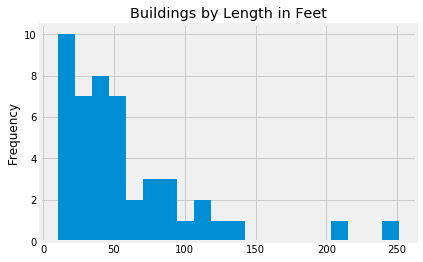

In [8]:
bldg_frontage_lengths.plot.hist(bins=20, title='Buildings by Length in Feet')

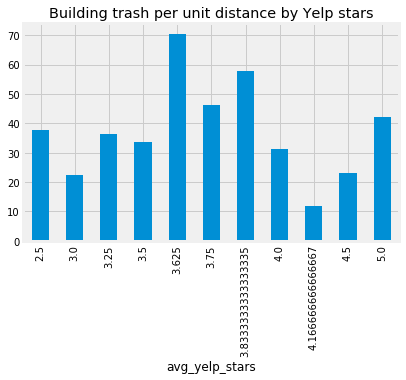

In [9]:
(trash
 .set_index('building_id')
 .join(buildings, how='left', lsuffix='_trash', rsuffix='_building')
 .groupby('avg_yelp_stars')
 .apply(lambda df: len(df) / bldg_frontage_lengths[df.index.unique()].sum())
 .plot.bar(title='Building trash per unit distance by Yelp stars')
)

There does seem to be something going on, but that 5.0 place ruins it visually. =P

Here are the two five-star businesses in the dataset FYI:

* https://www.yelp.com/biz/belso-home-and-garden-by-fl-pp-san-francisco
* https://www.yelp.com/biz/optical-works-eyewear-san-francisco

Let's calculate unit length in feet. From `01`:

> A [quick distance calculation](http://boulter.com/gps/distance/?from=-122.422525%2C++37.799694&to=-122.421525%2C+++37.799694&units=k) shows that 0.001 coordinate degrees in San Francisco is roughly 0.11 kilometers, or 110 meters, or 360 feet, or 0.068 miles. We'll normalize to feet because we're filthy Americans.

In [10]:
bldg_trash_per_unit_length = (
 trash
 .set_index('building_id')
 .join(buildings, how='left', lsuffix='_trash', rsuffix='_building')
 .reset_index()
 .groupby('building_id')
 .apply(lambda df: len(df) / bldg_frontage_lengths[df.name])
 .rename('trash_density')
 .to_frame()
 .assign(avg_yelp_stars=buildings['avg_yelp_stars'])
)

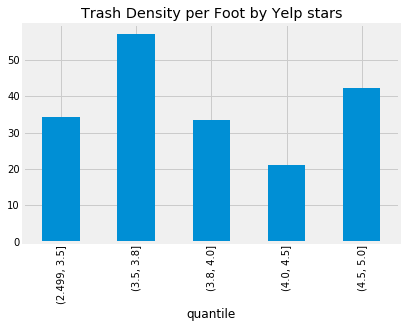

In [11]:
(bldg_trash_per_unit_length
 .assign(quantile=pd.qcut(bldg_trash_per_unit_length.avg_yelp_stars, 5).values)
 .groupby('quantile')
 .trash_density
 .mean()
 .plot.bar(title='Trash Density per Foot by Yelp stars')
)

In [12]:
(bldg_trash_per_unit_length
 .assign(quantile=pd.qcut(bldg_trash_per_unit_length.avg_yelp_stars, 5).values)
 .groupby('quantile')
 .count()
)

,trash_density,avg_yelp_stars
quantile,,
"(2.499, 3.5]",10,10
"(3.5, 3.8]",4,4
"(3.8, 4.0]",8,8
"(4.0, 4.5]",11,11
"(4.5, 5.0]",2,2


On the one hand we don't see an effect in the 4.5 to 5 range, on the other hand these are some really weird splitting rules for `qcut`, which purports to be a quantile splitting algorithm. These bins are all different sizes, for some reason.

In [13]:
(bldg_trash_per_unit_length
 .assign(category=pd.cut(bldg_trash_per_unit_length.avg_yelp_stars, [2.49, 3.5, 4.0, 5.1]).values)
 .groupby('category')
 .count()
)

,trash_density,avg_yelp_stars
category,,
"(2.49, 3.5]",10,10
"(3.5, 4.0]",12,12
"(4.0, 5.1]",13,13


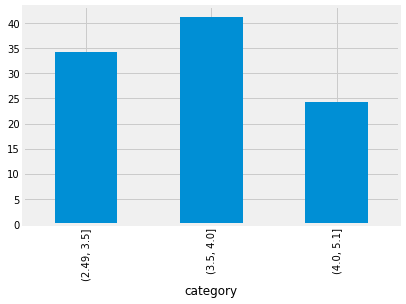

In [14]:
(bldg_trash_per_unit_length
 .assign(category=pd.cut(bldg_trash_per_unit_length.avg_yelp_stars, [2.49, 3.5, 4.0, 5.1]).values)
 .groupby('category')
 .trash_density
 .mean()
 .plot.bar()
)

Much better. However, this is such a small number of observations (just ~10 per class!) that we probably need to use error bars:

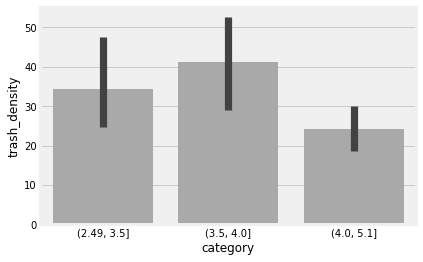

In [15]:
import seaborn as sns
sns.barplot(
    x="category", y="trash_density",
    data=(bldg_trash_per_unit_length
          .assign(category=pd.cut(bldg_trash_per_unit_length.avg_yelp_stars, [2.49, 3.5, 4.0, 5.1]).values)),
    color='darkgray'
)

This properly indicates to the user that, hey, we're not working with a lot of data here! For analytical purposes, here's a swarmplot of the same data, which underlines just how small our sample space is:

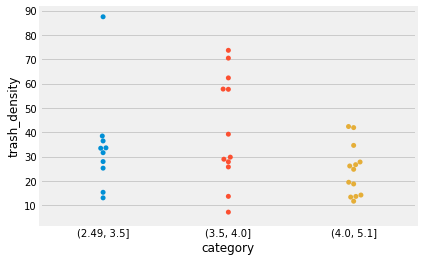

In [16]:
sns.swarmplot(
    x="category", y="trash_density",
    data=(bldg_trash_per_unit_length
          .assign(category=pd.cut(bldg_trash_per_unit_length.avg_yelp_stars, [2.49, 3.5, 4.0, 5.1]).values)),
)

Let's adjust the scale and make this look nice.

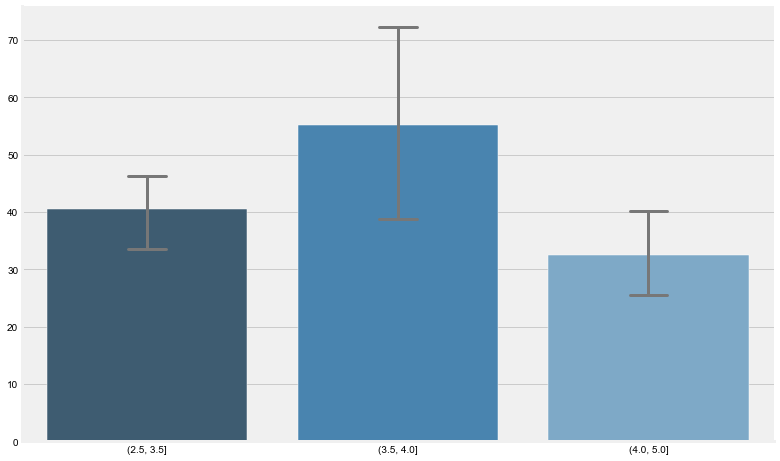

In [17]:
fig, ax = plt.subplots(1, figsize=(12, 8))
plt.style.use('seaborn-poster')
sns.set_style('white')

sns.barplot(
    x="category", y="trash_density",
    data=(
        bldg_trash_per_unit_length
        .assign(
            category=pd.cut(bldg_trash_per_unit_length.avg_yelp_stars, [2.5, 3.5, 4.0, 5.0]).values,
            trash_density = (
                bldg_trash_per_unit_length.trash_density /  # data is in terms of trash per foot, all time
                (trash.time.max() - trash.time.min()).days *  # normalize to trash per foot per day
                365  # then normalize to trash per foot per year
            )
        )
    ),
    color='lightgreen', ax=ax, capsize=.15, errwidth=3, errcolor='#777777', palette="Blues_d"
)
ax.set_xlabel(None)
# ax.set_ylabel('Trash per Foot (Yearly)')
ax.set_ylabel(None)
sns.despine()

Let's repeat this process on Yelp dollars.

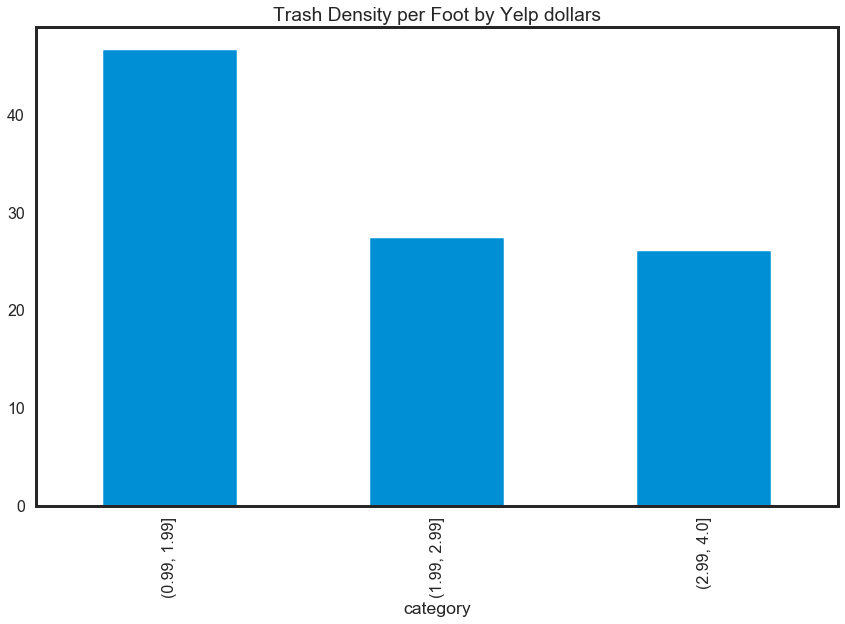

In [18]:
(bldg_trash_per_unit_length
 .assign(category=pd.cut(buildings.avg_yelp_dollars, [0.99, 1.99, 2.99, 4]))
 .groupby('category')
 .trash_density
 .mean()
 .plot.bar(title='Trash Density per Foot by Yelp dollars')
)

Yelp dollars do not seem to have a strong effect.

## Visual idea two: categorical story

Next we look at the data distribution in front of the buildings.

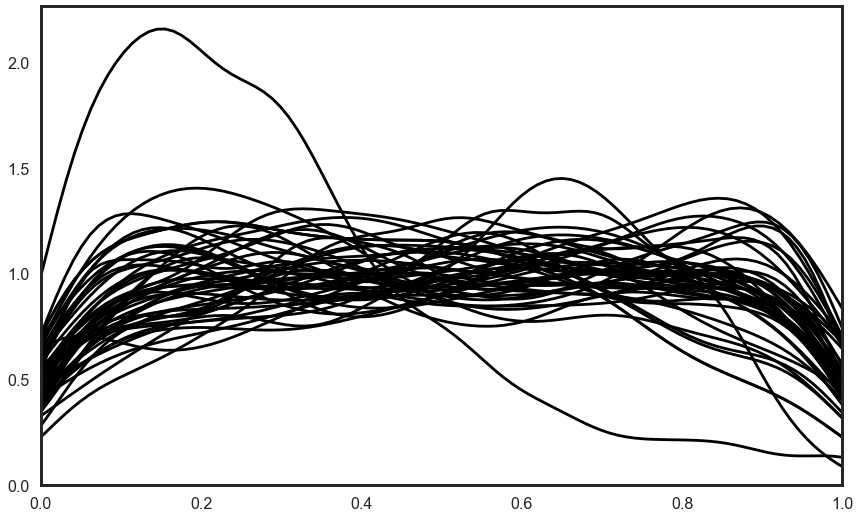

In [19]:
def plot_bldg_trash(df, ax):
    df = df.assign(
        perc_dist=(
            (df.snap_distance - df.snap_distance.min()) / 
            (df.snap_distance.max() - df.snap_distance.min())
        )
    )
    sns.kdeplot(data=df.perc_dist, ax=ax, color='black')

ax = plt.gca()
(trash
 .groupby('building_id')
 .apply(lambda df: plot_bldg_trash(df, ax))
)
ax.set_xlim(0, 1)
ax.get_legend().remove()

This is a `kdeplot`, so it's an estimator on the distribution function. Certain locations have bumps in their trash distribution near the tails, but in the mean case trash is pretty linear, e.g. the volume of trash is smooth across the entire storefront.

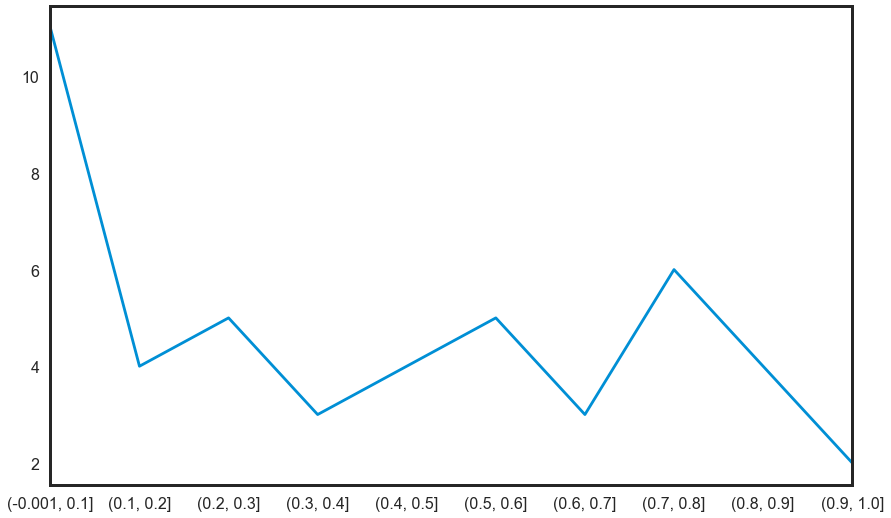

In [20]:
def plot_bldg_trash(df, ax):
    df = df.assign(
        perc_dist=(
            (df.snap_distance - df.snap_distance.min()) / 
            (df.snap_distance.max() - df.snap_distance.min())
        )
    )
    pd.cut(df.perc_dist, 10).value_counts().sort_index().plot.line(ax=ax)

s = (trash
 .groupby('building_id')
 .head(1)
)
plot_bldg_trash(s, plt.gca())

OK, here is a plot of all of the bars.

""


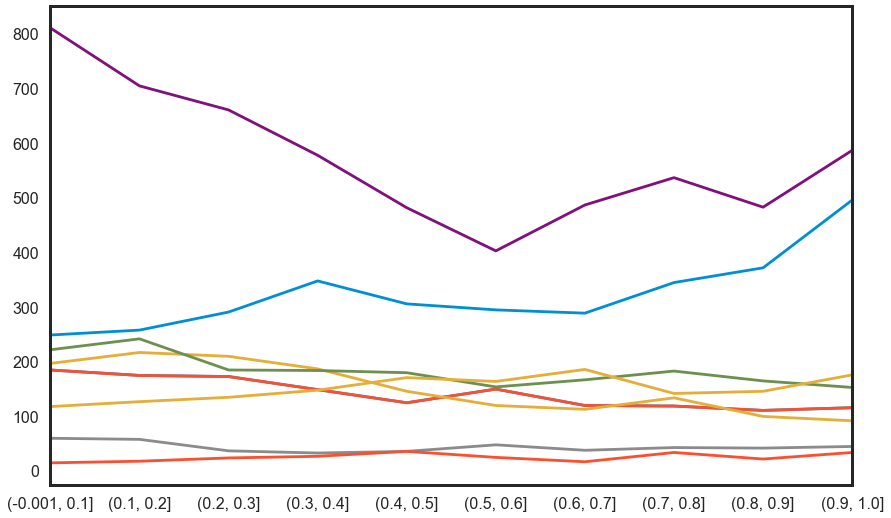

In [21]:
def plot_bldg_trash(df, ax):
    df = df.assign(
        perc_dist=(
            (df.snap_distance - df.snap_distance.min()) / 
            (df.snap_distance.max() - df.snap_distance.min())
        )
    )
    pd.cut(df.perc_dist, 10).value_counts().sort_index().plot.line(ax=ax)

ax = plt.gca()
(trash[trash.building_id.isin(buildings.query('has_bar == True').index)]
 .groupby('building_id')
 .apply(lambda df: plot_bldg_trash(df, ax))
)

There is one really dirty building that dominates this dataset!

""


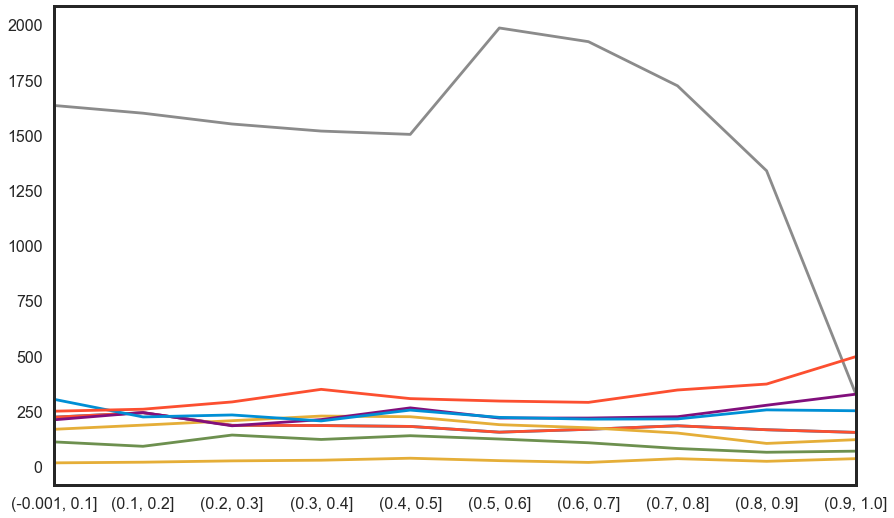

In [22]:
ax = plt.gca()
(trash[trash.building_id.isin(buildings.query('has_restaurant == True').index)]
 .groupby('building_id')
 .apply(lambda df: plot_bldg_trash(df, ax))
)

""


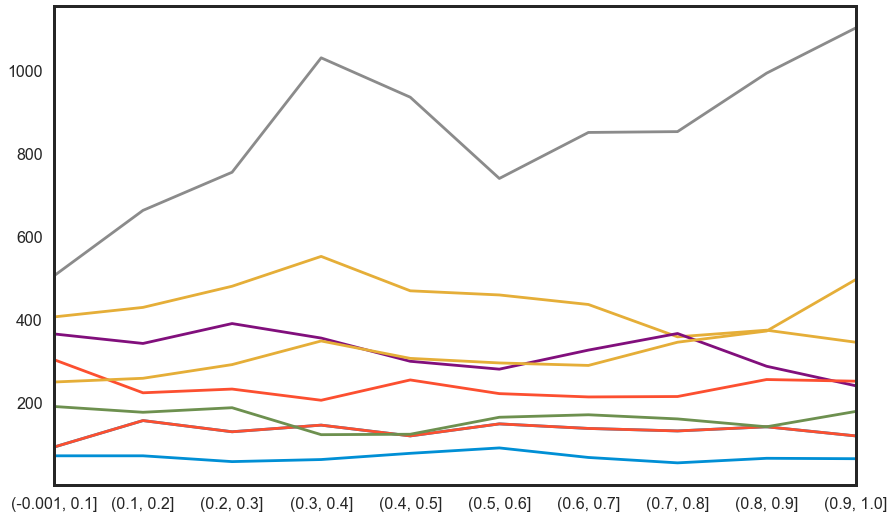

In [23]:
ax = plt.gca()
(trash[trash.building_id.isin(buildings.query('has_coffee_shop == True').index)]
 .groupby('building_id')
 .apply(lambda df: plot_bldg_trash(df, ax))
)

In fact, no matter what business type we pick, interestingly enough there always seems to be one business that squeezes all of the other businesses out on the y axis.

In [24]:
rows = []

for c in [c for c in buildings.columns if 'has_' in c]:
    _type = c[4:]
    for building_id, srs in buildings[c].iteritems():
        if buildings.loc[building_id, 'has_' + _type]:
            rows.append([building_id, _type])

bldg_business_types = (
    pd.DataFrame(rows, columns=['building_id', 'business_type'])
    .set_index('building_id')
    .assign(trash_rate=bldg_trash_per_unit_length.trash_density)
)

In [25]:
bldg_business_types[bldg_business_types.business_type.isin(['bar', 'restaurant', 'coffee shop', 'laundromat', 'salon'])]

,business_type,trash_rate
building_id,,
D32097DD_5E72_4125_8BB1_8590C4CFFB33,bar,57.715528
C64D3FDB_CF39_412F_BDF9_C1C3867738E1,bar,62.401271
FCC0D9EB_D614_4055_A3A3_DB3D904B959F,bar,73.733577
20310060_D1C6_4715_84BC_70AA48DE916A,bar,31.663178
160C3C1F_347E_480A_B890_130B43C7A97D,bar,34.659196
504D27C7_8110_45EA_960F_CC1965FBB564,bar,25.313723
FB1BE0F4_6014_4D9C_AA0D_E4A2B844A60A,bar,11.720933
4BA419C4_FA2F_4F24_8FE4_831B67815447,bar,57.812542
8127AC2E_1D16_4781_AE54_DA60A5A2E215,laundromat,13.715295


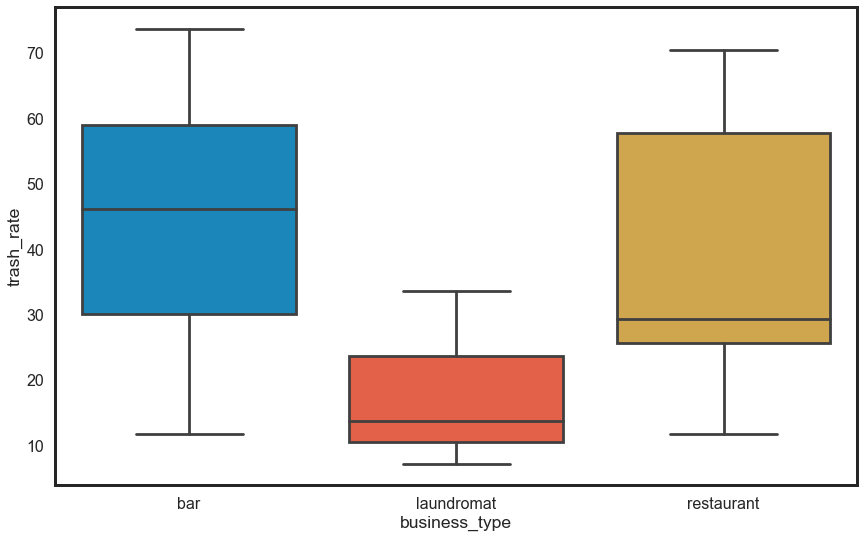

In [26]:
sns.boxplot(
    data=bldg_business_types[
        bldg_business_types.business_type.isin(['bar', 'restaurant', 'coffee shop', 'laundromat'])
    ],
    x='business_type', y='trash_rate'
)

The sample size is simply too small for this to a visually effective plot: there are just not enough categories with rich enough data.

## Generating assets for a block-level plot

These assets were blended together in Inkscape to make the block-aligned plot.

In [27]:
# fig, ax = plt.subplots(1, figsize=(12, 2))
# plt.style.use('seaborn-poster')
# sns.set_style('white')
# plt.axis('off')

# pd.cut(trash.query("side == 'left'")['snap_distance'], 100).value_counts().sort_index().plot.line()
# ax.set_ylim((0, 1500))

In [28]:
# fig, ax = plt.subplots(1, figsize=(12, 2))
# plt.style.use('seaborn-poster')
# sns.set_style('white')
# plt.axis('off')

# pd.cut(trash.query("side == 'right'")['snap_distance'], 100).value_counts().sort_index().plot.line()
# ax.set_ylim((0, 1500))

In [29]:
# gplt.choropleth(
#     blocks.geometry.scale(xfact=0.80, yfact=0.80).sort_index(),
#     # facecolor='lightgray', edgecolor='None',
#     # zorder=-2,
#     # figsize=(12, 12),
#     hue=trash.block_id.value_counts().sort_index(), cmap='Reds', edgecolor='black', linewidth=2,
#     extent=blocks.geometry.scale(xfact=1.1, yfact=1.1).total_bounds
# )

In [32]:
# np.vstack(
#     (pd.cut(trash.query("side == 'left'")['snap_distance'], 100).value_counts().sort_index().values,
#      pd.cut(trash.query("side == 'right'")['snap_distance'], 100).value_counts().sort_index().values)
# )

In [33]:
# this street point code copied from an earlier notebook
street_points = blocks.iloc[[0, 1, 5, 6]].geometry.map(lambda geom: Point(geom.bounds[0], geom.bounds[1]))
net.snapobservations(street_points, 'street_points')
updated_street_points = spgh.element_as_gdf(net, pp_name='street_points', snapped=True)

# they need to be conveted to categories...
cats = pd.cut(trash.query("side == 'left'")['snap_distance'], 100).values.categories
updated_street_points = (updated_street_points
 .distance(Point(*frontages.total_bounds[[0, 3]])) * (360 / 0.001)
).pipe(lambda srs: pd.cut(srs, bins=cats))

# and those categories need to be indexed by location, b/c we're just using range(100) in the stackplot
updated_street_points = np.hstack(([0], np.sort(updated_street_points.cat.codes.values)))

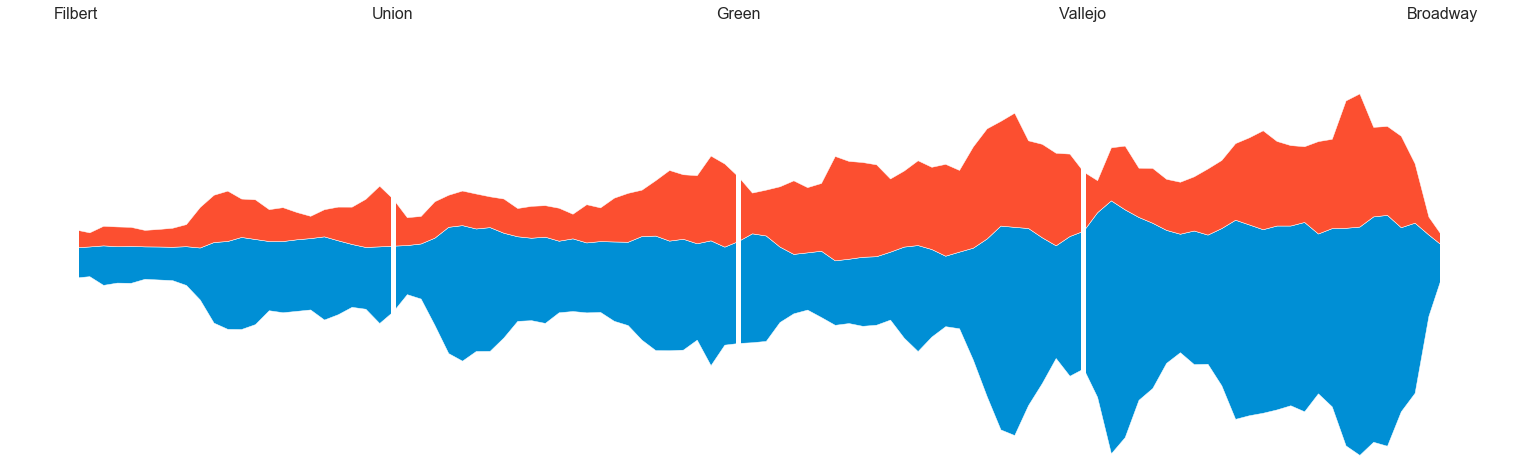

In [34]:
fig, ax = plt.subplots(figsize=(24, 8))
ax.stackplot(
    range(100),
    np.vstack(
    (pd.cut(trash.query("side == 'left'")['snap_distance'], 100).value_counts().sort_index().values,
     pd.cut(trash.query("side == 'right'")['snap_distance'], 100).value_counts().sort_index().values)),
    baseline='wiggle'
)
sns.despine(left=True, bottom=True)
ax.set_ylim([-1200, 1200])
ax.set_yticks([])

for v in updated_street_points:
    ax.axvline(v, color='white', linewidth=5)

plt.xticks(updated_street_points, ['Filbert', 'Union', 'Green', 'Vallejo', 'Broadway'])
ax.xaxis.tick_top()

I positioned the text labels by hand, as doing so that way is faster than juking around with text positions in `matplotlb`.

In [ ]:
from IPython.display import Image
Image('../../imgs/streamgraph.png')